
# Project: Car price prediction

## Table of Contents
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#exp">Exploring the datasat</a></li>
    <li><a href="#prep">Model preperation</a></li>
    <li><a href="#knn">KNN</a></li>
    <li><a href="#log">Logistic Regression</a></li>
    <li><a href="#bayes">Naive Bayes</a></li>
    <li><a href="#conc">Conclusion</a></li>
</ul>

<a id='intro'></a>
# Introduction

### Dataset Description 
The data used in this project contains some pre-defined standard symptoms. These symptoms are
based on guidelines given by the World Health Organization (WHO).<br>
This dataset has daily level information on the number of affected cases, deaths and recovery from
2019 novel coronavirus.

### Main goal:
#### Identify whether a person is going to recover from coronavirus symptoms or not

In [1]:
# Import needed packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score,auc


<a id='exp'></a>
# Explore the data set
Let us start by importing the dataset and having a look on it

In [2]:
df = pd.read_csv('data.csv',index_col='Unnamed: 0')
df.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [3]:
df.shape

(863, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      863 non-null    int64  
 1   country       863 non-null    int64  
 2   gender        863 non-null    int64  
 3   age           863 non-null    float64
 4   vis_wuhan     863 non-null    int64  
 5   from_wuhan    863 non-null    int64  
 6   symptom1      863 non-null    int64  
 7   symptom2      863 non-null    int64  
 8   symptom3      863 non-null    int64  
 9   symptom4      863 non-null    int64  
 10  symptom5      863 non-null    int64  
 11  symptom6      863 non-null    int64  
 12  diff_sym_hos  863 non-null    int64  
 13  result        863 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 101.1 KB


Thankfully, the data is already cleaned and preprocesse. So, let us cut to the chase and start modeling

<a id='prep'></a>
# Model preperation
In this section, We are going to split the data and define the functions that will be used for later.

## Split into train and test

In [5]:
# Separate target from predictors
y = df.result
X = df.drop('result', axis=1)

# Divide data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=42)

### Plot functions

In [6]:
def plot_roc(y_test,preds,model):
    """ 
    Plot the ROC curve  

    Parameters
    ----------
    y_test : pandas.Series
        the true values that we will predict
    preds : numpy.ndarray
        the predicted values
    model : str
        the name of the model

    Return
    ------ 
    A plot of the roc curve for the given model 
    """
    fpr, tpr, thresh = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print('roc_auc_score for {}: '.format(model), roc_auc_score(y_test, preds))
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [7]:
def plot_report(y_test, preds,targets = None):
    """ 
    Plot classification report 

    Parameters
    ----------
    y_test : pandas.Series
        the true values that we will predict
    preds : numpy.ndarray
        the predicted values
    target_names : list
        A list that contains the target classes names

    Return
    ------ 
    Classification report plot 
    """
    clf_report = classification_report(y_test,
                                       preds,
                                       target_names=targets,
                                       output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

<a id='knn'></a>
# KNN

Before fitting the model, we need to scale our data values. We will do that using ***StandardScaler*** from sklearn library.
We are going to implement a pipeline that first scales the data and then apply our estimator

In [8]:
pipe = Pipeline(steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# Hyperparameters to be tuned
grid_params = { 'knn__n_neighbors' : list(range(1,16)),
               'knn__weights' : ['uniform','distance'],
               'knn__metric' : ['minkowski','euclidean','manhattan']}

grid = GridSearchCV(pipe, grid_params, cv=5, scoring='f1', n_jobs=-1,verbose=1)

# Fit the grid
grid.fit(X_train,y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n{}".format(grid.best_params_))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best cross-validation score: 0.75
Best parameters: 
{'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [9]:
# Use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance',algorithm = 'brute',metric = 'manhattan')
knn.fit(X_train, y_train)
preds_prob = knn.predict_proba(X_test)[:, 1]
preds = knn.predict(X_test)

roc_auc_score for KNN:  0.9857142857142857


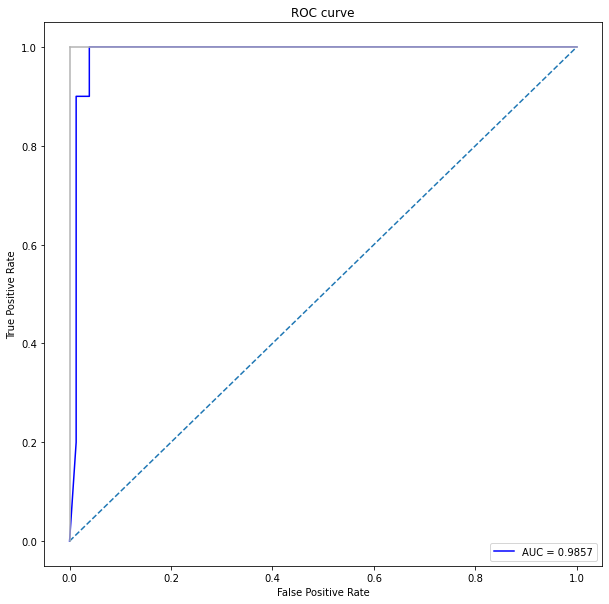

In [10]:
plot_roc(y_test,preds_prob,'KNN')

> Auc score of 0.9857 shows that the model can distinguish between the classes very well

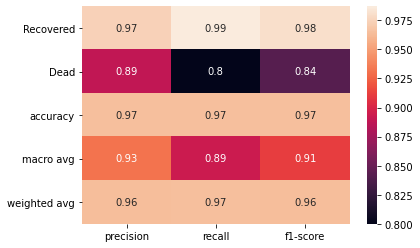

In [11]:
plot_report(y_test,preds,['Recovered','Dead'])

> The scores here are well-balanced. Precision and recall for the recovered class are higher but that is predictable given that it is the dominant class.

<a id='log'></a>
# Logistic Regression

In [12]:
pipe = Pipeline(steps = [('scaler', StandardScaler()), ('logistic', LogisticRegression())])

# Hyperparameters to be tuned
grid_params = { 'logistic__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
               'logistic__penalty' : ['l2','l1'],
               'logistic__C' : [100, 10, 1.0, 0.1, 0.01]}

grid = GridSearchCV(pipe, grid_params, cv=5, scoring='recall', n_jobs=-1,verbose=1)

# Fit the grid
grid.fit(X_train,y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n{}".format(grid.best_params_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\C\conda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67052632 0.67052632 0.67052632        nan        nan 0.67052632
 0.67052632 0.67052632 0.67052632        nan        nan 0.67052632
 0.66052632 0.66052632 0.66052632        nan        nan 0.67052632
 0.54894737 0.54894737 0.61052632        nan        nan 0.58789474
 0.04052632 0.04052632 0.37684211        nan        nan 0.        ]
  warnings.warn(


Best cross-validation score: 0.67
Best parameters: 
{'logistic__C': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'newton-cg'}


In [13]:
# Use the best hyperparameters
log = LogisticRegression(solver = 'newton-cg', C=100 ,penalty = 'l2')
log.fit(X_train, y_train)
preds_prob = log.predict_proba(X_test)[:, 1]
preds = log.predict(X_test)

roc_auc_score for Logistic Regression:  0.9090909090909092


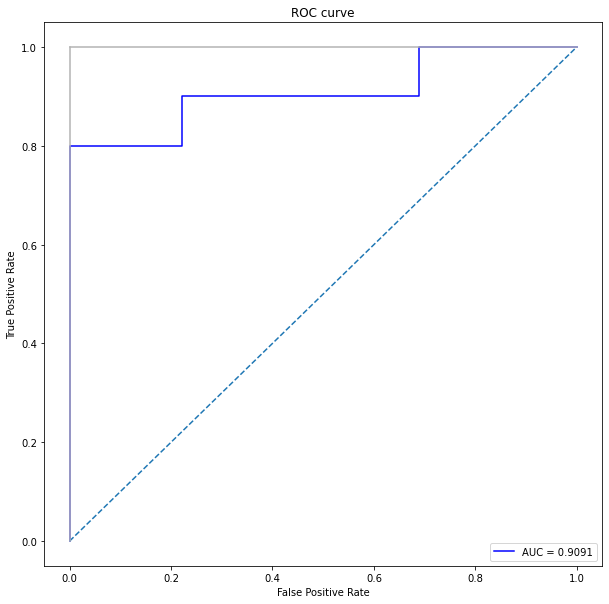

In [14]:
plot_roc(y_test,preds_prob,'Logistic Regression')

> Auc score of 0.9 shows that the model can distinguish between the classes well. But this is a lower score than Knn's.

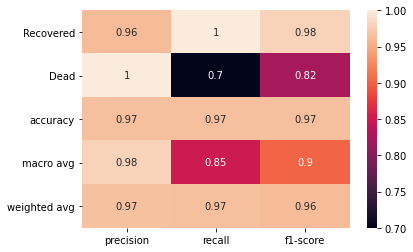

In [15]:
plot_report(y_test,preds,['Recovered','Dead'])

> We can see that this model can very well indentify the recovered class with a FN value of zero. But unfortunately, it trades this with the recall of the dead class wich is more important.

<a id='bayes'></a>
# Naive Bayes

There are a lot of naive bayes models out there. <br>
The famous ones are:
<ul>
    <li><b>Gaussian Naive Bayes</b>: implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian.</li>
<li><b>Multinomial Naive Bayes</b>: implements the naive Bayes algorithm for multinomially distributed data.</li>
<li><b>Complement Naive Bayes</b>: implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets.</li>
<li><b>Bernolli Naive Bayes</b>: implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions.</li>
<li><b>Categorical Naive Bayes</b>: implements the categorical naive Bayes algorithm for categorically distributed data.</li>   
</ul>
So far, we believe Categorical Naive Bayes algorithm is the most suitable candidate given the datasets at our hands which is composed of mostly categorical data. But because our data contains negative values, we are forced to use GaussianDB. Other way is to use ComplementNB which is used for imbalanced data. So, we are going to test it and then deal with the negative values and try the categoricalDB to see which one of the three is better is better.

As Naive Bayes algorithm is based on probability not on distance, so it doesn't require feature scaling. It has no hyperparametrs also.

### GaussianDB

In [16]:
gauss = GaussianNB()
gauss.fit(X_train,y_train)
preds_prob = gauss.predict_proba(X_test)[:, 1]
preds = gauss.predict(X_test)

roc_auc_score for Gaussian Naive Bayes:  0.8792207792207792


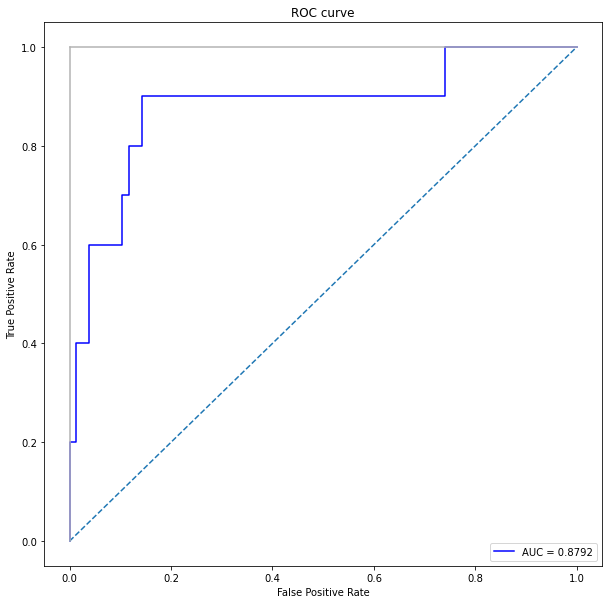

In [17]:
plot_roc(y_test,preds_prob,'Gaussian Naive Bayes')

> Auc score of 0.88 shows that the model can distinguish between the classes well. But it is less than the first two models'.

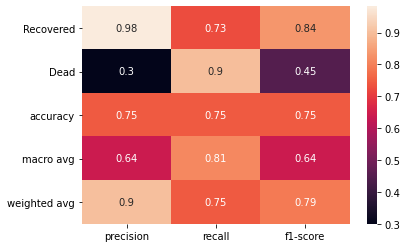

In [18]:
plot_report(y_test,preds,['Recovered','Dead'])

> This model has the highest dead class recall score. In other words, it can distinguish dead patients very well. But the precision recall trade-off is just too high which means that the model tends to predict the patients as dead more often than there actually are. 

### CategorcalDB

ValueError: Negative values in data passed to ComplementNB (input X) is shown to us. We are going to replace negative values in our data by zero

In [19]:
df['diff_sym_hos']=df['diff_sym_hos'].apply(lambda x: x if x>=0 else 0)

Now, lets split again

In [20]:
# Separate target from predictors
y = df.result
X = df.drop('result', axis=1)

# Divide data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=42)

In [21]:
cat = CategoricalNB()
cat.fit(X_train,y_train)
preds_prob = cat.predict_proba(X_test)[:, 1]
preds = cat.predict(X_test)

roc_auc_score for Categorical Naive Bayes:  0.8896103896103896


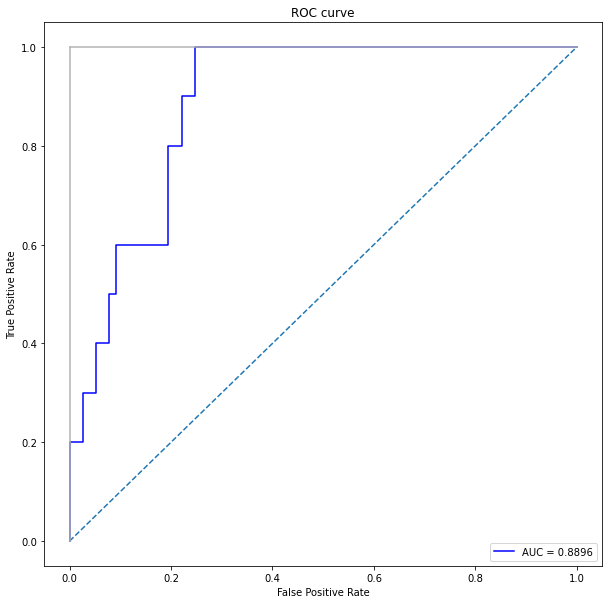

In [22]:
plot_roc(y_test,preds_prob,'Categorical Naive Bayes')

> Auc score of 0.89 shows that the model can distinguish between the classes well. It is less than the first two models' but higher than the gaussian's.

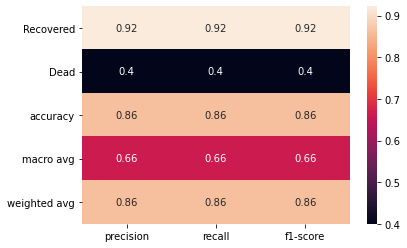

In [23]:
plot_report(y_test,preds,['Recovered','Dead'])

> Our belief that the categorical nive bayes is better than the gaussian is not hardly proven here. This model does not go well with the dead class which is essential. So, we will stick with the gaussian model as the representative of Naive Bayes.

### ComplementNB

ComplementNB is used for imbalanced data which is the case here so lets check its performance

In [24]:
comp = ComplementNB()
comp.fit(X_train,y_train)
preds_prob = comp.predict_proba(X_test)[:, 1]
preds = comp.predict(X_test)

roc_auc_score for Categorical Naive Bayes:  0.8506493506493508


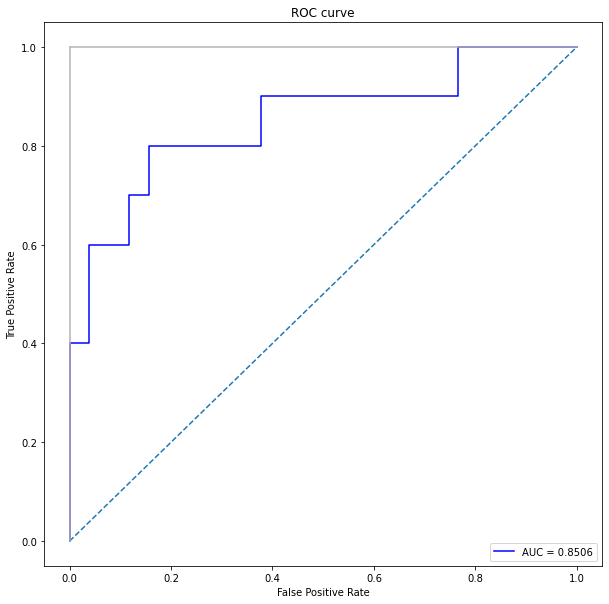

In [25]:
plot_roc(y_test,preds_prob,'Categorical Naive Bayes')

> Auc score of 0.85 shows that the model can distinguish between the classes well. It is considered the lowest amongst the others.

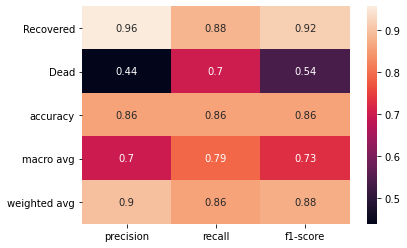

In [26]:
plot_report(y_test,preds,['Recovered','Dead'])

> Its scores seem more balanced then the other two but let us stick with the gaussian for the recall's sake

<a id='conc'></a>
# Conclusion

Given this data, we are more concerned in predicting the dead class to be able to treat those and gie them a higher priority. <br>
Before getting to the best model, we will first summarize the scores:

1. The model with the best AUC score is the **KNN** model
2. The model with the best f1-score is the **KNN** model
3. The model with the best dead class precision is the **Logistic Regression** model
4. The model with the best dead class recall is the **Naive Bayes** model
5. The model with the best recovered class precision is the **Naive Bayes** model
6. The model with the best recovered class recall is the **Logistic Regression** model

The challenge here is tough with a draw between the three models. But, we just considered which model is best in which criteria we did not consider how the model is bad in each criteria. Given that in mind, **KNN** model is the most well balanced model out there and its recall score for the dead class is very acceptable.